In [5]:
import datetime as dt

import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from numbers import Number

In [6]:
%matplotlib inline

mpl.rcParams["font.size"] = 16
mpl.rcParams["figure.figsize"] = (14, 7)

In [7]:
import wmfdata as wmf
from wmfdata.utils import sig_figs

In [8]:
FILE = "metrics/metrics.tsv"

# Data loading and transformation

In [9]:
metrics = pd.read_csv(FILE, sep="\t", parse_dates=["month"]).set_index("month")

# Calculate existing active editors and insert in a logical position
ae_idx = metrics.columns.get_loc("active_editors")
eae_vals = metrics["active_editors"] - metrics["new_active_editors"] - metrics["second_month_active_editors"]
metrics.insert(ae_idx + 1, "existing_active_editors", eae_vals)

# Calculate total mobile edits and insert
mwe_idx = metrics.columns.get_loc("mobile_web_edits")
me_vals = metrics["mobile_web_edits"] + metrics["mobile_app_edits"]
metrics.insert(mwe_idx, "mobile_edits", me_vals)

# Drop columns that aren't key metrics
metrics = metrics.drop(["mobile_web_edits", "mobile_app_edits"], axis=1)

metrics.tail()

,total_edits,mobile_edits,nonbot_edits,active_editors,existing_active_editors,new_active_editors,second_month_active_editors,uploads,data_edits,new_editor_retention,total_content,wikipedia_articles,files,wikidata_entities
month,,,,,,,,,,,,,,
2018-01-01,39437710.0,1153243.0,20374752.0,84422,64391.0,16678.0,3353.0,675791.0,9749202.0,0.077362,179327186.0,47347214.0,47271845.0,44320994.0
2018-02-01,39574449.0,1011393.0,19934503.0,78963,59777.0,15052.0,4134.0,725015.0,15704642.0,0.066914,183394041.0,47509635.0,48260398.0,47011459.0
2018-03-01,43003671.0,1121184.0,25176956.0,86190,64218.0,17625.0,4347.0,809162.0,17996980.0,0.064066,185726550.0,47710088.0,49303612.0,47837922.0
2018-04-01,34530321.0,1107284.0,20762284.0,83705,62907.0,16059.0,4739.0,634360.0,12851269.0,NaN,188284127.0,47883204.0,50291095.0,48986646.0
2018-05-01,39061950.0,1165558.0,22231556.0,85424,63569.0,17787.0,4068.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Report

In [10]:
def fmt_num(x):
    if isinstance(x, Number):
        x = sig_figs(x, 3)
        
        if x < 5:
            return pct(x)
        else:
            return "{:,.0f}".format(x)
    else:
        return x

def pct(n):
    return "{:.1%}".format(n)

def find_latest(ser):
    nn_ser = ser[~ser.isnull()]
    return nn_ser.index[-1].date()

def calc_rpt(ser):
    nn_ser = ser[~ser.isnull()]
    cur_mo = nn_ser.index[-1].date()
    cur = nn_ser[-1]
    mo_prev = nn_ser[-2]
    yr_prev = nn_ser[-13]
    mom_change = (cur / mo_prev) - 1
    yoy_change = (cur / yr_prev) - 1
    
    res = [cur_mo, cur, mom_change, yoy_change]
    return pd.Series(
        [fmt_num(n) for n in res],
        index=["latest_month", "value", "mom_change", "yoy_change"]
    )

In [11]:
metrics.apply(calc_rpt).transpose()

,latest_month,value,mom_change,yoy_change
total_edits,2018-05-01,"39,100,000",13.1%,-6.6%
mobile_edits,2018-05-01,"1,170,000",5.3%,36.5%
nonbot_edits,2018-05-01,"22,200,000",7.1%,17.8%
active_editors,2018-05-01,"85,400",2.1%,-0.9%
existing_active_editors,2018-05-01,"63,600",1.1%,2.4%
new_active_editors,2018-05-01,"17,800",10.8%,-9.4%
second_month_active_editors,2018-05-01,"4,070",-14.2%,-8.4%
uploads,2018-04-01,"634,000",-21.6%,1.7%
data_edits,2018-04-01,"12,900,000",-28.6%,47.1%
new_editor_retention,2018-03-01,6.4%,-4.3%,6.7%


# Graphs

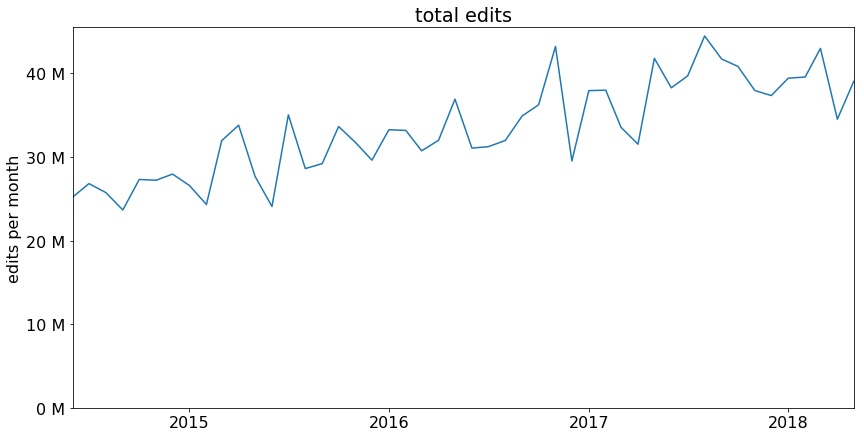

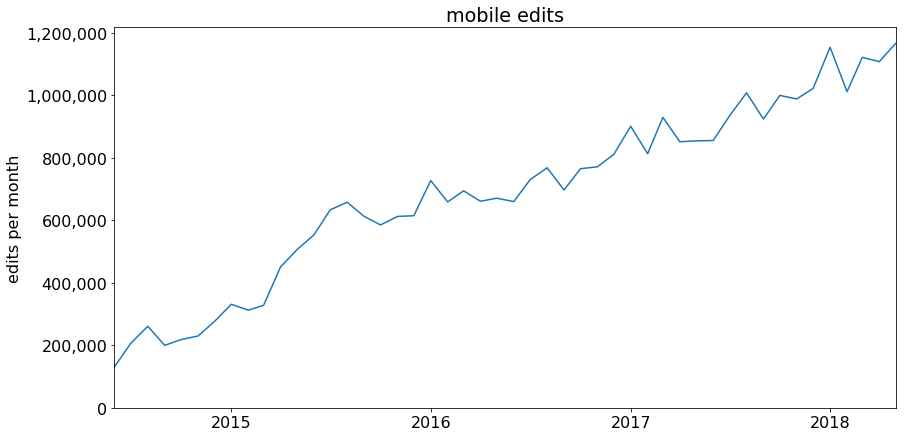

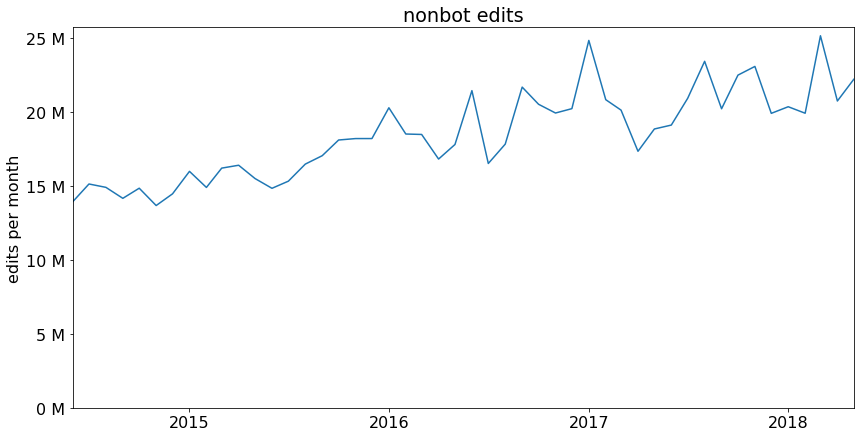

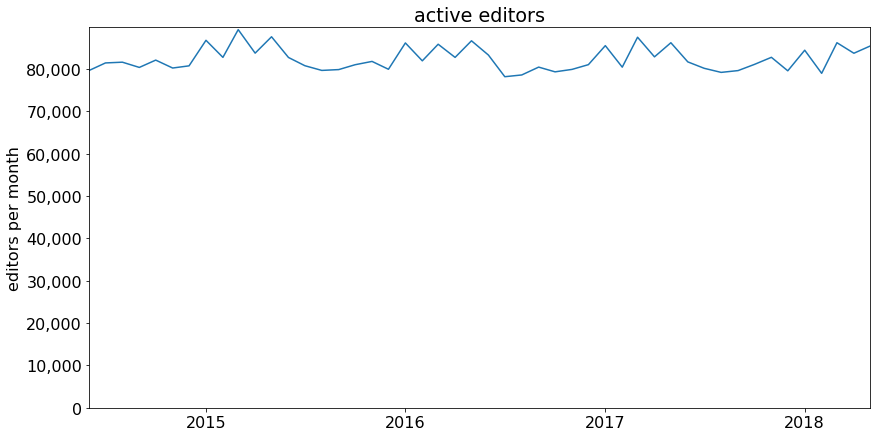

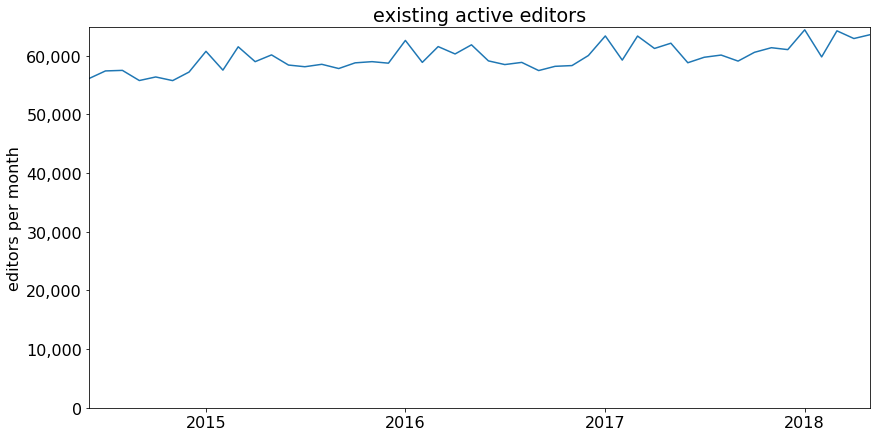

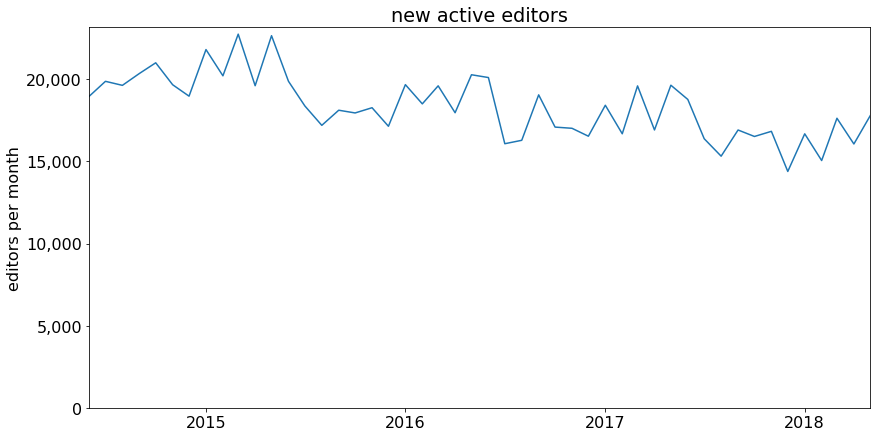

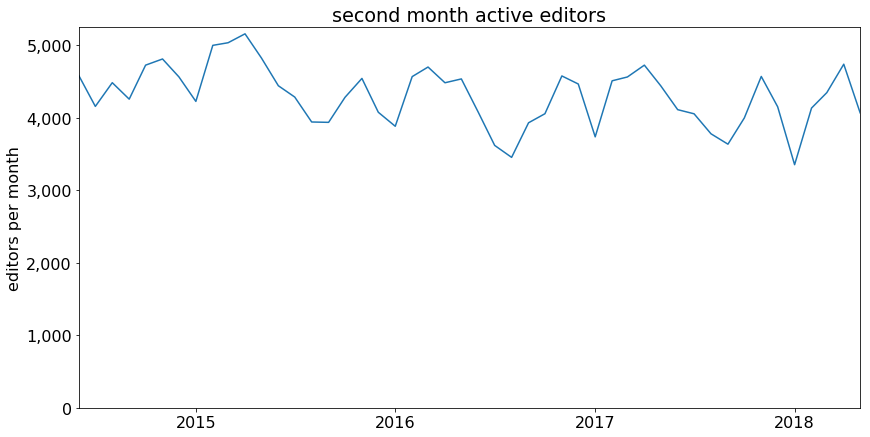

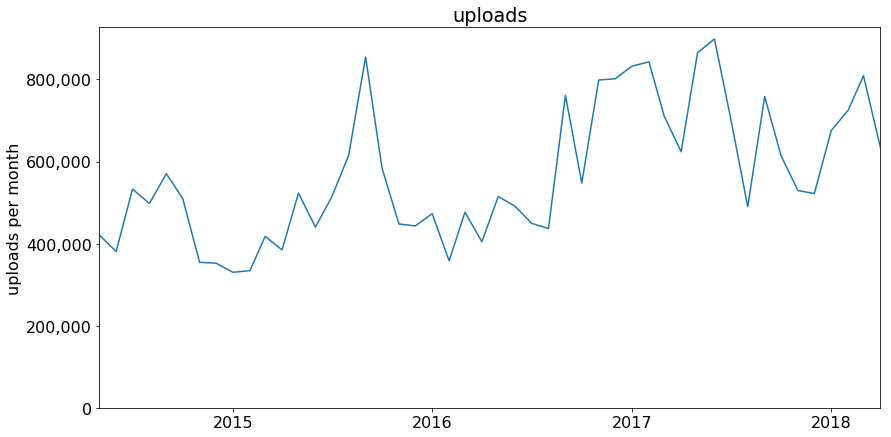

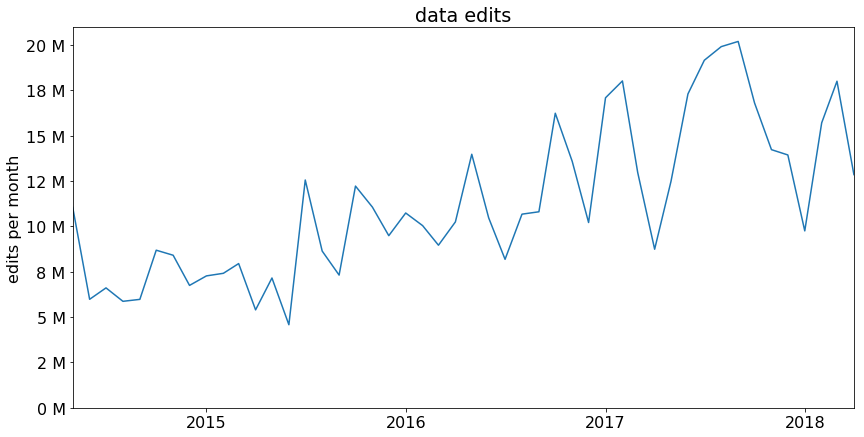

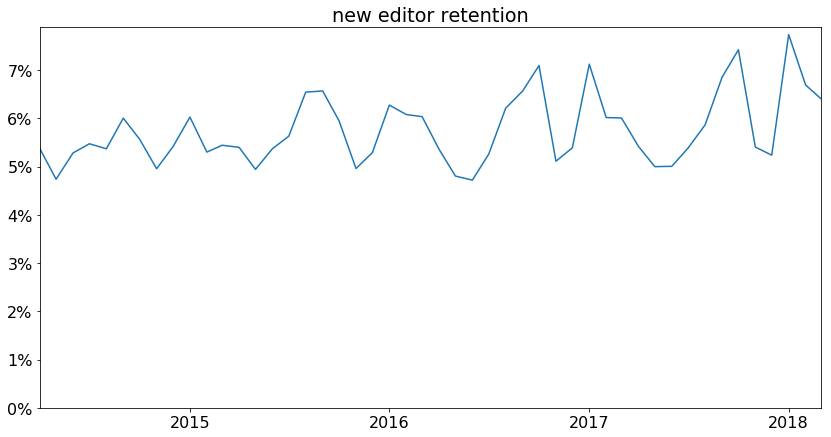

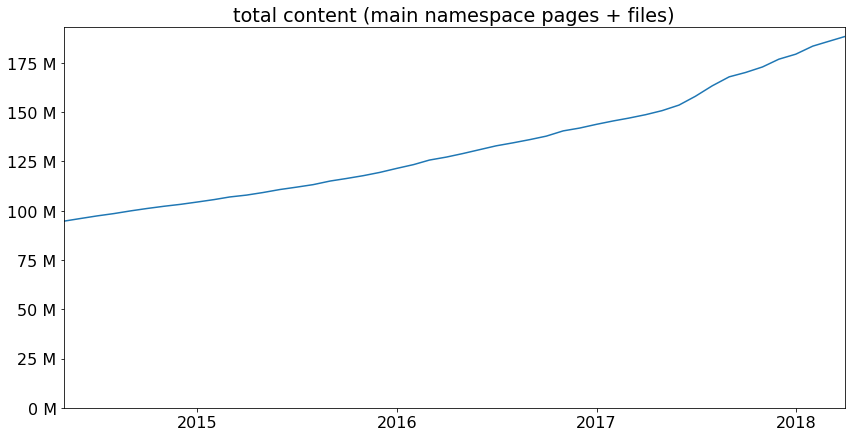

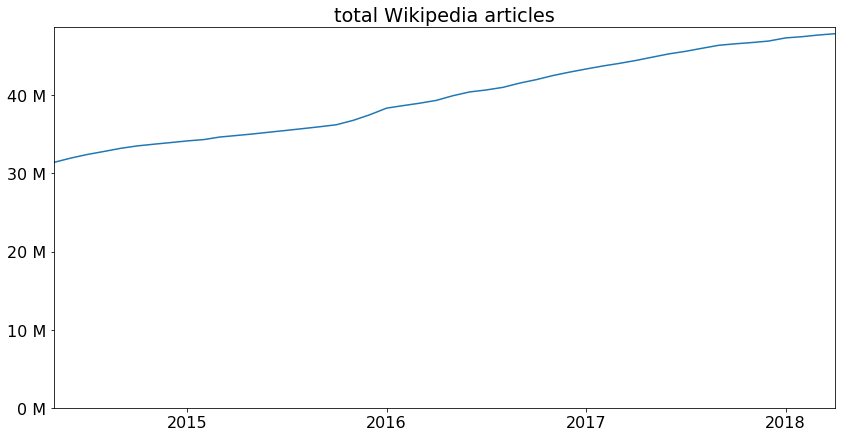

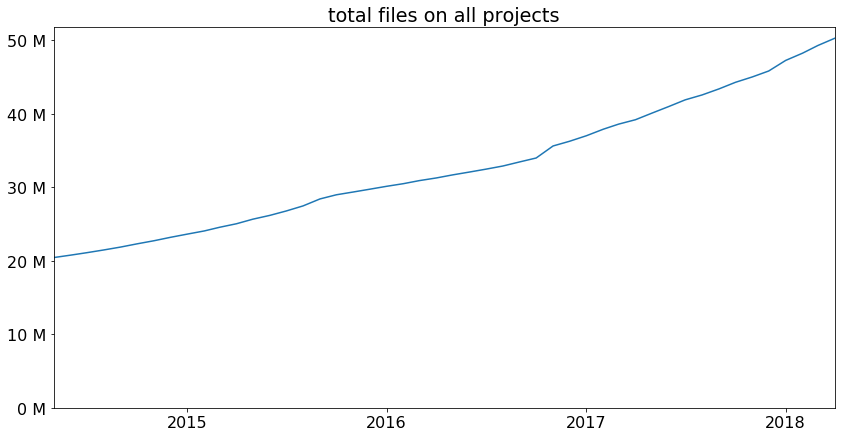

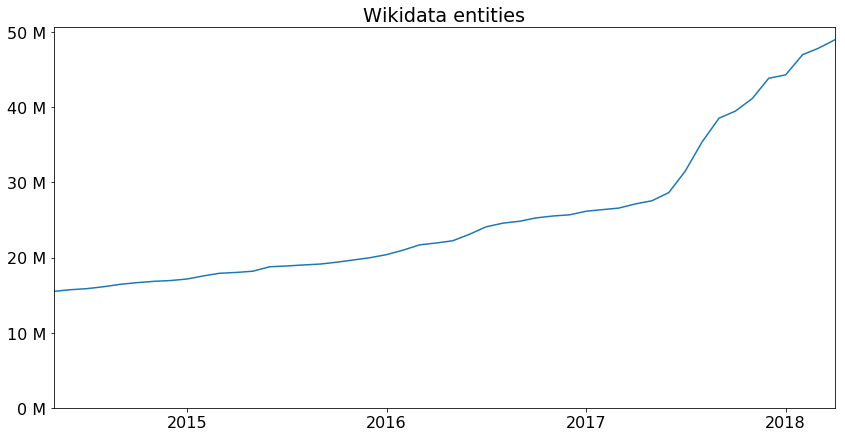

In [12]:
def M_str(x, pos):
    n = int(round(x / 1000000))
    return "{n} M".format(n=n)

M_fmt = mpl.ticker.FuncFormatter(M_str)

pct_fmt = mpl.ticker.PercentFormatter(xmax=1, decimals=0)

comma_fmt = mpl.ticker.StrMethodFormatter("{x:,.0f}")

graph_cfg = {
    "active_editors": {
        "y_lab": "editors per month"
    },
    "existing_active_editors": {
        "y_lab": "editors per month"
    },
    "new_active_editors": {
        "y_lab": "editors per month"
    },
    "second_month_active_editors": {
        "y_lab": "editors per month"
    },
    "total_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "mobile_edits": {
        "y_lab": "edits per month"
    },
    "nonbot_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "new_editor_retention": {
        "y_fmt": pct_fmt
    },
    "uploads": {
        "y_lab": "uploads per month"
    },
    "data_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "total_content": {
        "y_fmt": M_fmt,
        "title": "total content (main namespace pages + files)"
    },
    "wikipedia_articles": {
        "y_fmt": M_fmt,
        "title": "total Wikipedia articles"
    },
    "files": {
        "y_fmt": M_fmt,
        "title": "total files on all projects"
    },
    "wikidata_entities": {
        "y_fmt": M_fmt,
        "title": "Wikidata entities"
    }
}

for name, col in metrics.iteritems():
    cfg = graph_cfg[name]
    plt.figure()

    end = find_latest(col)
    start = end - relativedelta(months = 47)
    plt.plot(col[start:end])

    plt.title(cfg.get("title", name.replace("_", " ")))
    plt.ylabel(cfg.get("y_lab", ""))
    plt.gca().xaxis.set_major_locator(mpl.dates.YearLocator())
    plt.gca().yaxis.set_major_formatter(cfg.get("y_fmt", comma_fmt))
        
    plt.ylim(ymin=0)
    plt.autoscale(enable=True, axis="x", tight=True)